🧩 Cell 1 — Notebook title & checklist (Markdown)

# MITRE/VT Results — Filtering & Graphs

**Input**: `./output/analysis_results.csv`  
**Output charts**: `./charts/*.png`

**What you can filter:**
- Families (by name, optional)
- Status (e.g., `success`)
- `first_seen` epoch range (optional)
- whether a row “has techniques” (optional)

> Tip: run all cells (top → bottom). If the CSV is missing, fix the path in the Config cell.


🧩 Cell 2 — Install libraries (only run if needed)

# If pandas/matplotlib are not available in your environment, uncomment and run:
# !pip install -q pandas matplotlib


🧩 Cell 3 — Imports

In [3]:
import os
from pathlib import Path
from datetime import datetime, timezone
from typing import List, Optional

import pandas as pd
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


🧩 Cell 4 — Config (EDIT THESE)

In [4]:
# ==== CONFIG ====

# Where is your CSV?
CSV_PATH = Path("./output/analysis_results.csv")

# Where to save charts
CHART_DIR = Path("./charts")

# Filters (edit as you like)
FILTER_FAMILIES: Optional[List[str]] = None      # e.g., ["Emotet", "Dridex", "Loki"]
FILTER_STATUS: Optional[str] = "success"         # set None to include all statuses
FILTER_FIRST_SEEN_MIN: Optional[int] = None      # e.g., 1609459200  # 2021-01-01 UTC
FILTER_FIRST_SEEN_MAX: Optional[int] = None      # e.g., 1704067200  # 2024-01-01 UTC
FILTER_HAS_TECHNIQUES: Optional[bool] = None     # True=only rows with techniques; False=only without; None=ignore

CHART_DIR.mkdir(parents=True, exist_ok=True)
print("✅ Config loaded")


✅ Config loaded


🧩 Cell 5 — Helpers (parsing & plotting)

In [5]:
def parse_ratio_to_pct(s):
    """Convert 'a/b' to percentage float (0..100)."""
    try:
        a, b = str(s).split("/")
        a, b = float(a), float(b)
        return (a / b * 100.0) if b else None
    except Exception:
        return None

def epoch_to_dt(x):
    """Convert epoch seconds to UTC datetime (or NaT)."""
    try:
        x = int(x)
        return datetime.fromtimestamp(x, tz=timezone.utc)
    except Exception:
        return pd.NaT

def savefig(path: Path):
    """Save the current matplotlib figure cleanly."""
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(path.as_posix(), dpi=150)
    plt.show()
    print(f"Saved: {path}")


🧩 Cell 6 — Load & normalize the data

In [6]:
if not CSV_PATH.exists():
    raise SystemExit(f"CSV not found: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

# Normalize column names/values expected by the rest of the notebook
if "family" not in df.columns and "malware_family" in df.columns:
    df["family"] = df["malware_family"]

for col, default in [("family", "Unknown"), ("source", "Unknown"), ("status", "")]:
    if col not in df.columns:
        df[col] = default
    df[col] = df[col].fillna(default)

# detection ratio → percentage
df["detection_rate_pct"] = df.get("detection_ratio", "").apply(parse_ratio_to_pct)

# epochs → datetimes
df["first_seen_dt"] = df.get("first_seen", None).apply(epoch_to_dt)
df["last_seen_dt"]  = df.get("last_seen", None).apply(epoch_to_dt)
df["first_seen_year"] = df["first_seen_dt"].dt.year

# techniques string → list + has_techniques flag
df["mitre_techniques"] = df.get("mitre_techniques", "").fillna("")
df["mitre_techniques_list"] = df["mitre_techniques"].apply(
    lambda s: [t.strip() for t in str(s).split(",") if str(t).strip()]
)
df["has_techniques"] = df["mitre_techniques_list"].apply(lambda L: len(L) > 0)

# make sure count columns are numeric
count_cols = [
    "dns_lookups_count", "ip_connections_count", "http_requests_count",
    "processes_count", "files_written_count", "files_deleted_count",
    "registry_keys_set_count", "mutexes_count", "mitre_techniques_count"
]
for c in count_cols:
    if c not in df.columns:
        df[c] = 0
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

print("✅ Loaded rows:", len(df))
df.head(3)


✅ Loaded rows: 100


,hash,family,source,status,detection_ratio,first_seen,last_seen,processes_count,files_written_count,files_deleted_count,...,mutexes_count,mitre_techniques_count,mitre_techniques,collected_date,detection_rate_pct,first_seen_dt,last_seen_dt,first_seen_year,mitre_techniques_list,has_techniques
0,818c482b0d6be6f5c9449c76d79edf4e038fe639267b2d...,Gozi,JAMESWT_WT,success,16/78,1696549101,1721357023,0,0,0,...,0,0,,2025-11-04T03:17:56.679772+00:00,20.512821,2023-10-05 23:38:21+00:00,2024-07-19 02:43:43+00:00,2023,[],False
1,68bd5e4a0955b5d2b89751532443e0c42ae2974d6fe900...,Loki,threatcat_ch,success,58/76,1746174671,1756451219,0,0,0,...,0,0,,2025-11-04T03:18:29.309932+00:00,76.315789,2025-05-02 08:31:11+00:00,2025-08-29 07:06:59+00:00,2025,[],False
2,68d60ea2de32a82a0e8675af68237a5184bd242ea3dc25...,Dridex,SecuriteInfoCom,success,49/76,1640185375,1741669328,0,0,0,...,0,0,,2025-11-04T03:19:02.200305+00:00,64.473684,2021-12-22 15:02:55+00:00,2025-03-11 05:02:08+00:00,2021,[],False


🧩 Cell 7 — Apply filters

In [7]:
mask = pd.Series([True] * len(df), index=df.index)

# by Family
if FILTER_FAMILIES:
    mask &= df["family"].isin(FILTER_FAMILIES)

# by Status
if FILTER_STATUS is not None:
    mask &= (df["status"] == FILTER_STATUS)

# by first_seen epoch range
if FILTER_FIRST_SEEN_MIN is not None:
    mask &= pd.to_numeric(df.get("first_seen", 0), errors="coerce").fillna(0) >= int(FILTER_FIRST_SEEN_MIN)
if FILTER_FIRST_SEEN_MAX is not None:
    mask &= pd.to_numeric(df.get("first_seen", 0), errors="coerce").fillna(0) <= int(FILTER_FIRST_SEEN_MAX)

# by “has techniques”
if FILTER_HAS_TECHNIQUES is True:
    mask &= df["has_techniques"]
elif FILTER_HAS_TECHNIQUES is False:
    mask &= ~df["has_techniques"]

df_f = df[mask].copy()
print("✅ Rows after filtering:", len(df_f))
df_f.head(5)


✅ Rows after filtering: 100


,hash,family,source,status,detection_ratio,first_seen,last_seen,processes_count,files_written_count,files_deleted_count,...,mutexes_count,mitre_techniques_count,mitre_techniques,collected_date,detection_rate_pct,first_seen_dt,last_seen_dt,first_seen_year,mitre_techniques_list,has_techniques
0,818c482b0d6be6f5c9449c76d79edf4e038fe639267b2d...,Gozi,JAMESWT_WT,success,16/78,1696549101,1721357023,0,0,0,...,0,0,,2025-11-04T03:17:56.679772+00:00,20.512821,2023-10-05 23:38:21+00:00,2024-07-19 02:43:43+00:00,2023,[],False
1,68bd5e4a0955b5d2b89751532443e0c42ae2974d6fe900...,Loki,threatcat_ch,success,58/76,1746174671,1756451219,0,0,0,...,0,0,,2025-11-04T03:18:29.309932+00:00,76.315789,2025-05-02 08:31:11+00:00,2025-08-29 07:06:59+00:00,2025,[],False
2,68d60ea2de32a82a0e8675af68237a5184bd242ea3dc25...,Dridex,SecuriteInfoCom,success,49/76,1640185375,1741669328,0,0,0,...,0,0,,2025-11-04T03:19:02.200305+00:00,64.473684,2021-12-22 15:02:55+00:00,2025-03-11 05:02:08+00:00,2021,[],False
3,fe135d63b84d72468b5e913b2b59ffd1e52911de7438d7...,AgentTesla,abuse_ch,success,28/76,1759905954,1761216318,0,0,0,...,0,0,,2025-11-04T03:19:34.728239+00:00,36.842105,2025-10-08 06:45:54+00:00,2025-10-23 10:45:18+00:00,2025,[],False
4,ae44cfb5daa272b11b29f5f69272d36aec1c24777e47b8...,TrickBot,zbetcheckin,success,41/72,1638929433,1639109457,0,0,0,...,0,0,,2025-11-04T03:20:07.334859+00:00,56.944444,2021-12-08 02:10:33+00:00,2021-12-10 04:10:57+00:00,2021,[],False


🧩 Cell 8 — Chart: Samples per family

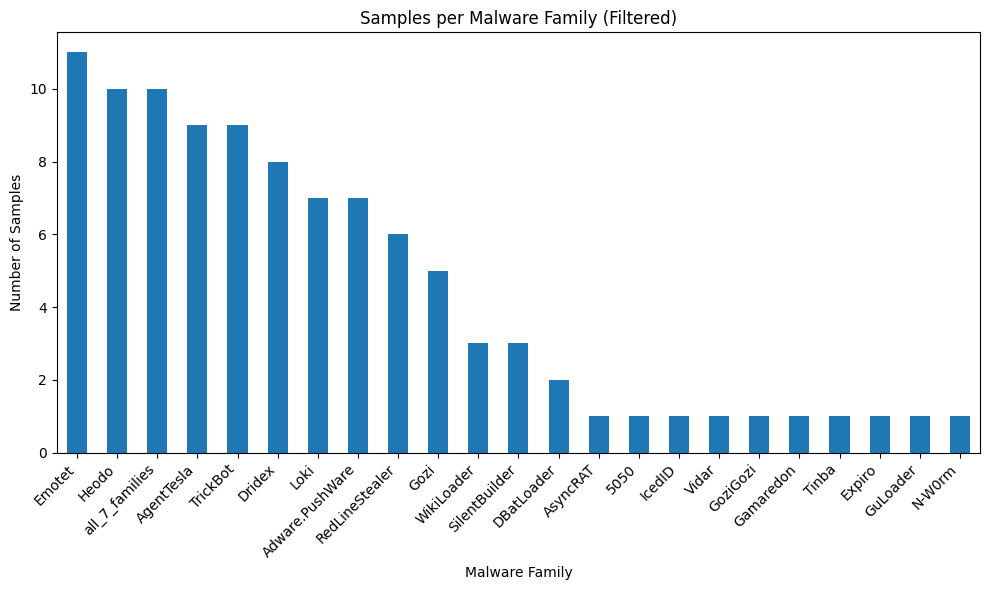

Saved: charts/samples_per_family.png


In [8]:
if df_f.empty:
    print("No data to plot. Adjust your filters and re-run.")
else:
    fam_counts = df_f["family"].value_counts().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    fam_counts.plot(kind="bar")
    plt.title("Samples per Malware Family (Filtered)")
    plt.xlabel("Malware Family")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45, ha="right")
    savefig(CHART_DIR / "samples_per_family.png")


🧩 Cell 9 — Chart: Detection rate histogram

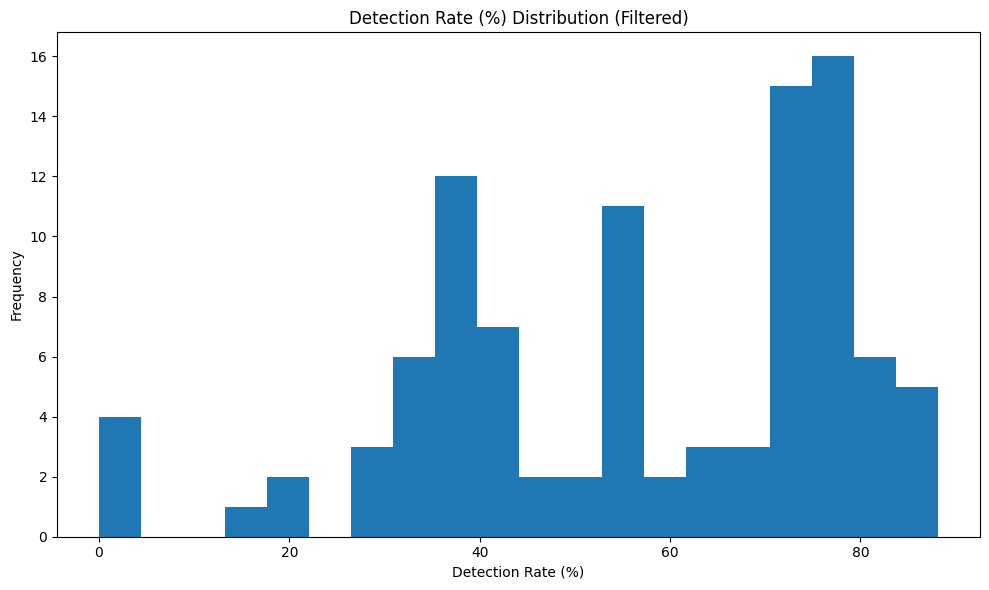

Saved: charts/detection_rate_hist.png


In [9]:
if df_f["detection_rate_pct"].notna().sum() > 0:
    plt.figure(figsize=(10, 6))
    df_f["detection_rate_pct"].dropna().plot(kind="hist", bins=20)
    plt.title("Detection Rate (%) Distribution (Filtered)")
    plt.xlabel("Detection Rate (%)")
    plt.ylabel("Frequency")
    savefig(CHART_DIR / "detection_rate_hist.png")
else:
    print("Skipped detection rate histogram (no detection_rate_pct values).")


🧩 Cell 10 — Chart: Top sources

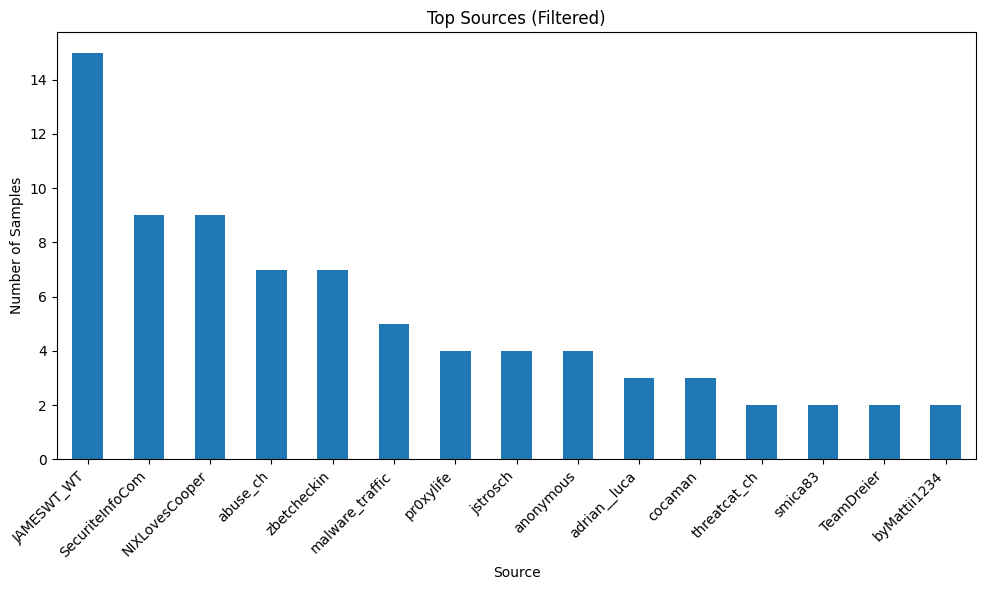

Saved: charts/top_sources.png


In [10]:
src_counts = df_f["source"].value_counts().head(15)
if len(src_counts) > 0:
    plt.figure(figsize=(10, 6))
    src_counts.plot(kind="bar")
    plt.title("Top Sources (Filtered)")
    plt.xlabel("Source")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45, ha="right")
    savefig(CHART_DIR / "top_sources.png")
else:
    print("Skipped Top Sources chart (no source data).")


🧩 Cell 11 — Chart: Samples by first_seen year

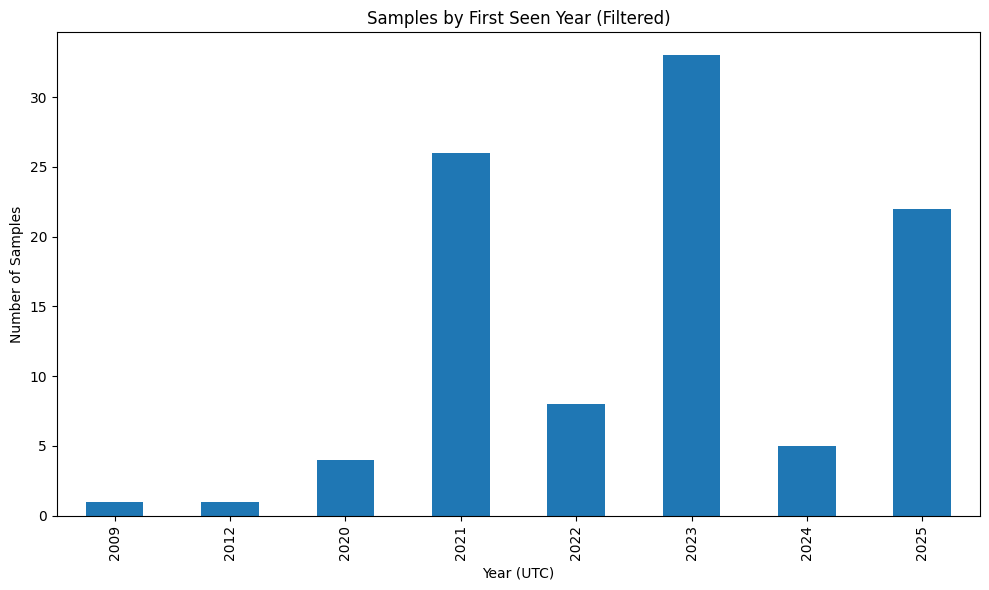

Saved: charts/samples_by_year.png


In [11]:
year_counts = df_f["first_seen_year"].dropna().value_counts().sort_index()
if len(year_counts) > 0:
    plt.figure(figsize=(10, 6))
    year_counts.plot(kind="bar")
    plt.title("Samples by First Seen Year (Filtered)")
    plt.xlabel("Year (UTC)")
    plt.ylabel("Number of Samples")
    savefig(CHART_DIR / "samples_by_year.png")
else:
    print("Skipped Samples by Year chart (no year data).")


🧩 Cell 12 — Chart: Average behavioral indicators per family

ℹ️ All behavioral indicator averages are zero — falling back to 'Average Detection Rate (%) per Family'.


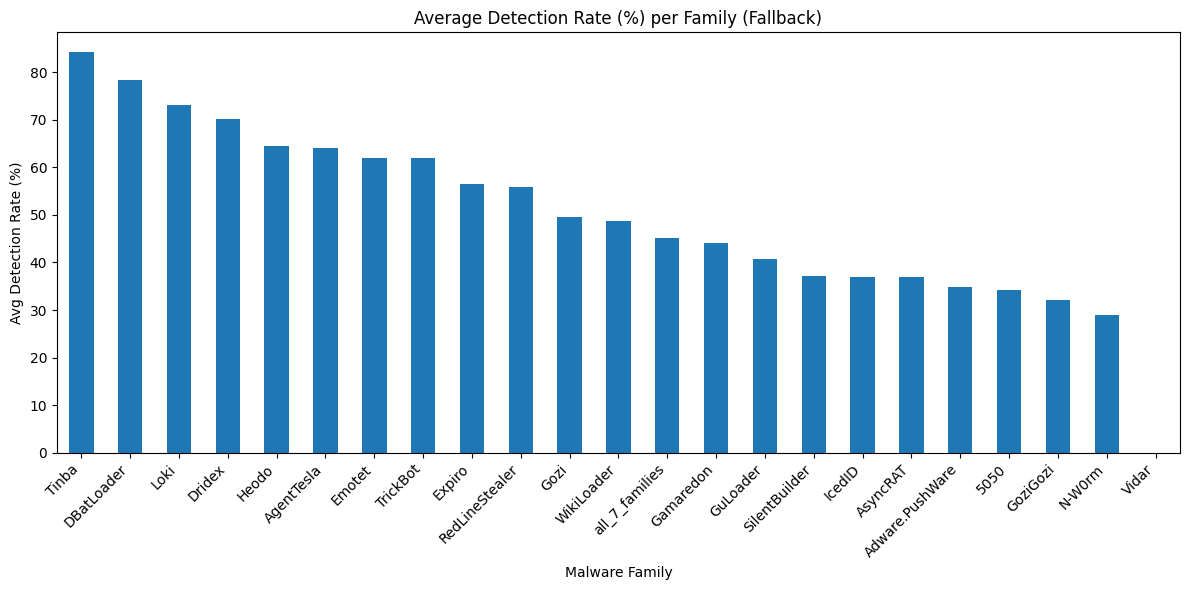

Saved: charts/avg_detection_rate_per_family_fallback.png


In [15]:
# indicator_cols = [
#     "dns_lookups_count", "ip_connections_count", "http_requests_count",
#     "processes_count", "files_written_count", "files_deleted_count",
#     "registry_keys_set_count"
# ]
# present = [c for c in indicator_cols if c in df_f.columns]
# if present:
#     fam_avg = df_f.groupby("family")[present].mean().sort_values(by=present[0], ascending=False)
#     ax = fam_avg.plot(kind="bar", figsize=(12, 7))
#     plt.title("Average Behavioral Indicators per Family (Filtered)")
#     plt.xlabel("Malware Family")
#     plt.ylabel("Average Count")
#     plt.xticks(rotation=45, ha="right")
#     plt.legend(title="Indicator", bbox_to_anchor=(1.02, 1), loc="upper left")
#     savefig(CHART_DIR / "avg_indicators_per_family.png")
# else:
#     print("Skipped Avg Indicators chart (no indicator columns).")



# 🧩 Cell 12 — Robust "Average behavioral indicators per family" with fallbacks

indicator_cols = [
    "dns_lookups_count", "ip_connections_count", "http_requests_count",
    "processes_count", "files_written_count", "files_deleted_count",
    "registry_keys_set_count"
]
present = [c for c in indicator_cols if c in df_f.columns]

if not present:
    print("Skipped Avg Indicators chart (no indicator columns in dataframe).")
else:
    # Average counts per family
    fam_avg = (
        df_f.groupby("family", dropna=False)[present]
            .mean()
            .fillna(0)
            .sort_values(by=present[0], ascending=False)
    )

    total_sum = float(fam_avg.values.sum()) if not fam_avg.empty else 0.0
    if fam_avg.empty or total_sum == 0.0:
        # Fallback #1: average detection rate per family
        alt = (
            df_f.groupby("family", dropna=False)["detection_rate_pct"]
                .mean()
                .dropna()
                .sort_values(ascending=False)
        )
        if not alt.empty:
            print("ℹ️ All behavioral indicator averages are zero — falling back to 'Average Detection Rate (%) per Family'.")
            plt.figure(figsize=(12, 6))
            alt.plot(kind="bar")
            plt.title("Average Detection Rate (%) per Family (Fallback)")
            plt.xlabel("Malware Family")
            plt.ylabel("Avg Detection Rate (%)")
            plt.xticks(rotation=45, ha="right")
            savefig(CHART_DIR / "avg_detection_rate_per_family_fallback.png")
        else:
            # Fallback #2: sample counts per family
            counts = df_f["family"].value_counts().sort_values(ascending=False)
            if counts.empty:
                print("No data after filtering; cannot plot.")
            else:
                print("ℹ️ No indicator or detection-rate data — falling back to 'Samples per Family'.")
                plt.figure(figsize=(12, 6))
                counts.plot(kind="bar")
                plt.title("Samples per Malware Family (Fallback)")
                plt.xlabel("Malware Family")
                plt.ylabel("Number of Samples")
                plt.xticks(rotation=45, ha="right")
                savefig(CHART_DIR / "samples_per_family_fallback.png")
    else:
        # Normal case: plot the average indicator bars
        ax = fam_avg.plot(kind="bar", figsize=(12, 7))
        plt.title("Average Behavioral Indicators per Family (Filtered)")
        plt.xlabel("Malware Family")
        plt.ylabel("Average Count")
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Indicator", bbox_to_anchor=(1.02, 1), loc="upper left")
        # If all bars are zero (flat line), force a small y-limit so axes are visible
        ymax = float(fam_avg.values.max()) if not fam_avg.empty else 0.0
        if ymax == 0.0:
            plt.ylim(0, 1)  # show a visible baseline
        savefig(CHART_DIR / "avg_indicators_per_family.png")



🧩 Cell 13 — Chart: Technique richness per family

ℹ️ No technique data available — falling back to 'Samples per Family'.


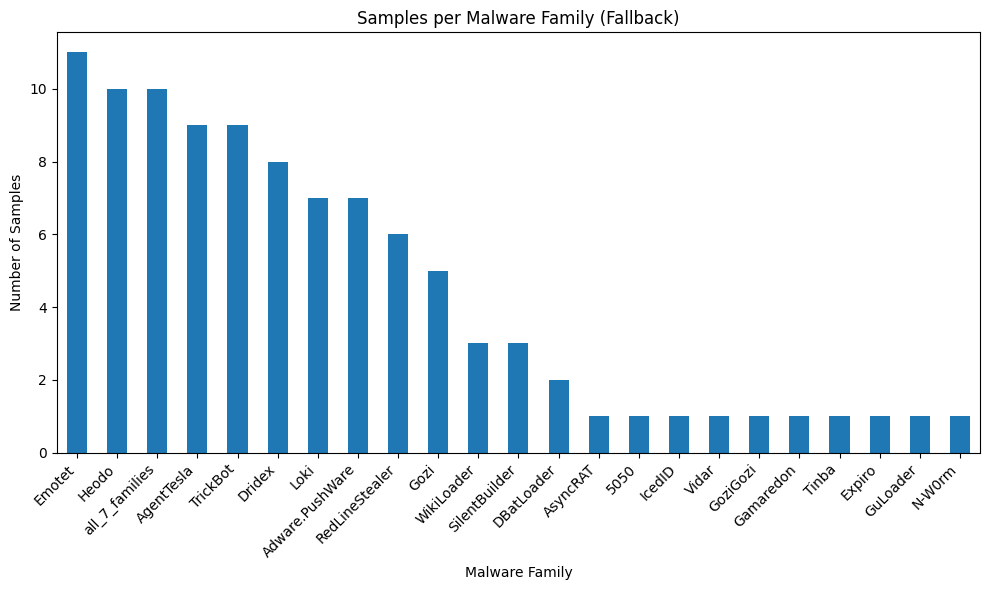

Saved: charts/samples_per_family_from_richness_fallback.png


In [16]:
# # Count unique technique IDs per family (handles empty strings gracefully)
# richness = df_f.groupby("family")["mitre_techniques_list"].apply(
#     lambda lists: len(set(t for L in lists for t in L))
# ).sort_values(ascending=False)

# plt.figure(figsize=(10, 6))
# richness.plot(kind="bar")
# plt.title("Technique Richness per Family (Unique MITRE Techniques)")
# plt.xlabel("Malware Family")
# plt.ylabel("Unique Techniques")
# plt.xticks(rotation=45, ha="right")
# savefig(CHART_DIR / "technique_richness_per_family.png")


# 🧩 Cell 13 — Robust "Technique richness per family" with fallbacks

# Count unique technique IDs per family; handle empties
richness = (
    df_f.groupby("family", dropna=False)["mitre_techniques_list"]
        .apply(lambda lists: len(set(t for L in lists for t in (L or []))))
        .sort_values(ascending=False)
)

if richness.empty or richness.sum() == 0:
    # Fallback #1: sum of mitre_techniques_count per family
    alt = (
        df_f.groupby("family", dropna=False)["mitre_techniques_count"]
            .sum()
            .sort_values(ascending=False)
    )
    if alt.sum() > 0:
        print("ℹ️ No explicit technique IDs found — falling back to 'Total MITRE Techniques Count per Family'.")
        plt.figure(figsize=(10, 6))
        alt.plot(kind="bar")
        plt.title("Total MITRE Techniques Count per Family (Fallback)")
        plt.xlabel("Malware Family")
        plt.ylabel("Sum of mitre_techniques_count")
        plt.xticks(rotation=45, ha="right")
        savefig(CHART_DIR / "mitre_count_per_family_fallback.png")
    else:
        # Fallback #2: samples per family
        counts = df_f["family"].value_counts().sort_values(ascending=False)
        if counts.empty:
            print("No data after filtering; cannot plot technique richness.")
        else:
            print("ℹ️ No technique data available — falling back to 'Samples per Family'.")
            plt.figure(figsize=(10, 6))
            counts.plot(kind="bar")
            plt.title("Samples per Malware Family (Fallback)")
            plt.xlabel("Malware Family")
            plt.ylabel("Number of Samples")
            plt.xticks(rotation=45, ha="right")
            savefig(CHART_DIR / "samples_per_family_from_richness_fallback.png")
else:
    plt.figure(figsize=(10, 6))
    richness.plot(kind="bar")
    plt.title("Technique Richness per Family (Unique MITRE Techniques)")
    plt.xlabel("Malware Family")
    plt.ylabel("Unique Techniques")
    plt.xticks(rotation=45, ha="right")
    # If all zeros, make it visible
    if richness.max() == 0:
        plt.ylim(0, 1)
    savefig(CHART_DIR / "technique_richness_per_family.png")


🧩 Cell 14 — Summary printout (Markdown-ish)

In [19]:
# print("===== FILTER SUMMARY =====")
# print(f"Families filter : {FILTER_FAMILIES or 'ALL'}")
# print(f"Status filter   : {FILTER_STATUS or 'ALL'}")
# print(f"First seen min  : {FILTER_FIRST_SEEN_MIN or 'None'}")
# print(f"First seen max  : {FILTER_FIRST_SEEN_MAX or 'None'}")
# print(f"Has techniques  : {FILTER_HAS_TECHNIQUES if FILTER_HAS_TECHNIQUES is not None else 'Ignore'}")
# print(f"Rows after filter: {len(df_f)}")
# print("\nCharts saved in:", CHART_DIR.resolve())



# 🧩 Cell 14 — Clean summary printout

def fmt_has_tech(x: Optional[bool]) -> str:
    if x is None:
        return "All"
    return "Only with techniques" if x else "Only without techniques"

def fmt_epoch(x: Optional[int]) -> str:
    if x is None:
        return "All"
    try:
        return f"{x} ({datetime.fromtimestamp(int(x), tz=timezone.utc).date()})"
    except Exception:
        return str(x)

print("===== FILTER SUMMARY =====")
print(f"Families filter : {', '.join(FILTER_FAMILIES) if FILTER_FAMILIES else 'All'}")
print(f"Status filter   : {FILTER_STATUS if FILTER_STATUS is not None else 'All'}")
print(f"First seen min  : {fmt_epoch(FILTER_FIRST_SEEN_MIN)}")
print(f"First seen max  : {fmt_epoch(FILTER_FIRST_SEEN_MAX)}")
print(f"Has techniques  : {fmt_has_tech(FILTER_HAS_TECHNIQUES)}")
print(f"Rows after filter: {len(df_f)}")

print("\nCharts saved in:", CHektedir := CHART_DIR.resolve())
for name in [
    "samples_per_family.png",
    "detection_rate_hist.png",
    "top_sources.png",
    "samples_by_year.png",
    "avg_indicators_per_family.png",
    "avg_detection_rate_per_family_fallback.png",
    "samples_per_family_fallback.png",
    "mitre_count_per_family_fallback.png",
    "technique_richness_per_family.png",
    "samples_per_family_from_richness_fallback.png",
]:
    p = CHART_DIR / name
    if p.exists():
        print("  -", p)



===== FILTER SUMMARY =====
Families filter : All
Status filter   : success
First seen min  : All
First seen max  : All
Has techniques  : All
Rows after filter: 100

Charts saved in: /Users/classroomservices/Documents/GitHub/CybersecurityProject/charts
  - charts/samples_per_family.png
  - charts/detection_rate_hist.png
  - charts/top_sources.png
  - charts/samples_by_year.png
  - charts/avg_indicators_per_family.png
  - charts/avg_detection_rate_per_family_fallback.png
  - charts/technique_richness_per_family.png
  - charts/samples_per_family_from_richness_fallback.png
